In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('./data/final_df')

In [3]:
df.head()

,WindSpeedX,WindSpeedY,WindSpeedZ,fcp4,fcp5,fcp6,fcp7,fcp8,fcp9,fcp10,...,fcp29,fcp30,fcp31,fcp32,fcp33,fcp34,fcp35,fcp36,Kp,ap
0,4.433160,-1.247880,-13.165854,72.649708,13.381961,62.895386,105.150254,126.192341,96.894005,129.308053,...,521.337944,488.062646,485.142165,447.935497,440.527809,420.749016,375.216954,400.725942,6.000,80.0
1,3.448769,-3.864323,-8.984068,139.338250,108.341150,131.678031,127.960636,124.528562,108.572063,108.378163,...,133.417875,156.115273,157.808188,151.744812,155.335281,159.891094,156.531719,165.816281,5.333,56.0
2,4.407694,-5.729229,-6.420560,143.819967,103.094027,126.340200,129.495920,124.643217,96.828230,90.773630,...,129.626667,155.001633,154.731300,146.782767,152.727733,159.018433,153.443367,162.591600,5.000,48.0
3,3.758710,-6.973925,3.080465,50.958930,4.106739,126.788959,112.982595,112.074751,123.493431,158.653164,...,496.077804,509.342792,487.738078,430.778801,397.022686,377.122228,341.428298,381.510963,3.333,18.0
4,6.514989,-6.250111,-0.786576,142.064460,102.750320,127.700920,130.539498,124.235998,73.482044,79.054954,...,132.570392,151.837784,149.355490,147.432392,154.934608,155.693529,150.167540,163.003080,1.667,6.0


In [5]:
X1 = df[["WindSpeedX", "WindSpeedY", "WindSpeedZ", "ap", "Kp"]]
X2 = df.iloc[:,7:10]
X = pd.concat((X2,X1), axis = 1).values


In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, int(len(X)*0.8)):
    X_train.append(X[i-60:i, :])
    y_train.append(X[i, 7])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 8))



# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 8)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',   
                               patience=5,            
                               restore_best_weights=True)  

# Entrenar el modelo con EarlyStopping
regressor.fit(X_train, y_train, 
              epochs=20,                     # Número máximo de épocas
              validation_split=0.2, callbacks=[early_stopping]) 

Epoch 1/20
342/342 [==============================] - 62s 146ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 2/20
342/342 [==============================] - 48s 141ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 3/20
342/342 [==============================] - 50s 145ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 4/20
342/342 [==============================] - 49s 144ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 5/20
342/342 [==============================] - 48s 141ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/20
342/342 [==============================] - 48s 141ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/20
342/342 [==============================] - 49s 144ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/20
342/342 [==============================] - 50s 146ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/20
342/342 [==============================] - 50s 146ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/20
342/342 [==============================] - 49s 142ms/step - l

108/108 [==============================] - 7s 42ms/step


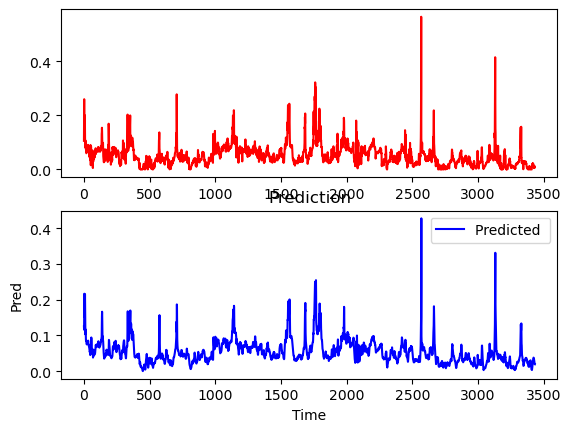

In [11]:
X_test = list()
y_test = list()
for i in range(int(len(X)*0.8), len(X)-1):
    X_test.append(X[i-60:i, :])
    y_test.append(X[i, 7])
X_test, y_test = np.array(X_test), np.array(y_test)

y_pred = regressor.predict(X_test)

plt.subplot(2,1,1)
plt.plot(y_test, color = 'red', label = 'Test')
plt.subplot(2,1,2)
plt.plot(y_pred, color = 'blue', label = 'Predicted ')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Pred')
plt.legend()
plt.show()

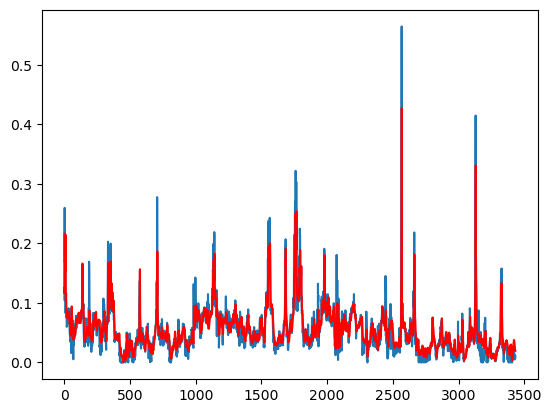

In [12]:
plt.plot(y_test)
plt.plot(y_pred,c='r')

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, int(len(X)*0.8)):
    X_train.append(X[i-60:i, :])
    y_train.append(X[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 8))



# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 8)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 8))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',   
                               patience=5,            
                               restore_best_weights=True)  

# Entrenar el modelo con EarlyStopping
regressor.fit(X_train, y_train, 
              epochs=20,                     # Número máximo de épocas
              validation_split=0.2, callbacks=[early_stopping]) 


X_test = list()
y_test = list()
for i in range(int(len(X)*0.8), len(X)-1):
    X_test.append(X[i-60:i, :])
    y_test.append(X[i, :])
X_test, y_test = np.array(X_test), np.array(y_test)
y_pred = regressor.predict(X_test)

Epoch 1/20
342/342 [==============================] - 61s 142ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 2/20
342/342 [==============================] - 48s 140ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 3/20
342/342 [==============================] - 48s 140ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/20
342/342 [==============================] - 49s 143ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/20
342/342 [==============================] - 50s 145ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/20
342/342 [==============================] - 45s 130ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/20
342/342 [==============================] - 48s 140ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/20
342/342 [==============================] - 49s 143ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/20
342/342 [==============================] - 49s 144ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/20
342/342 [==============================] - 50s 146ms/step - l

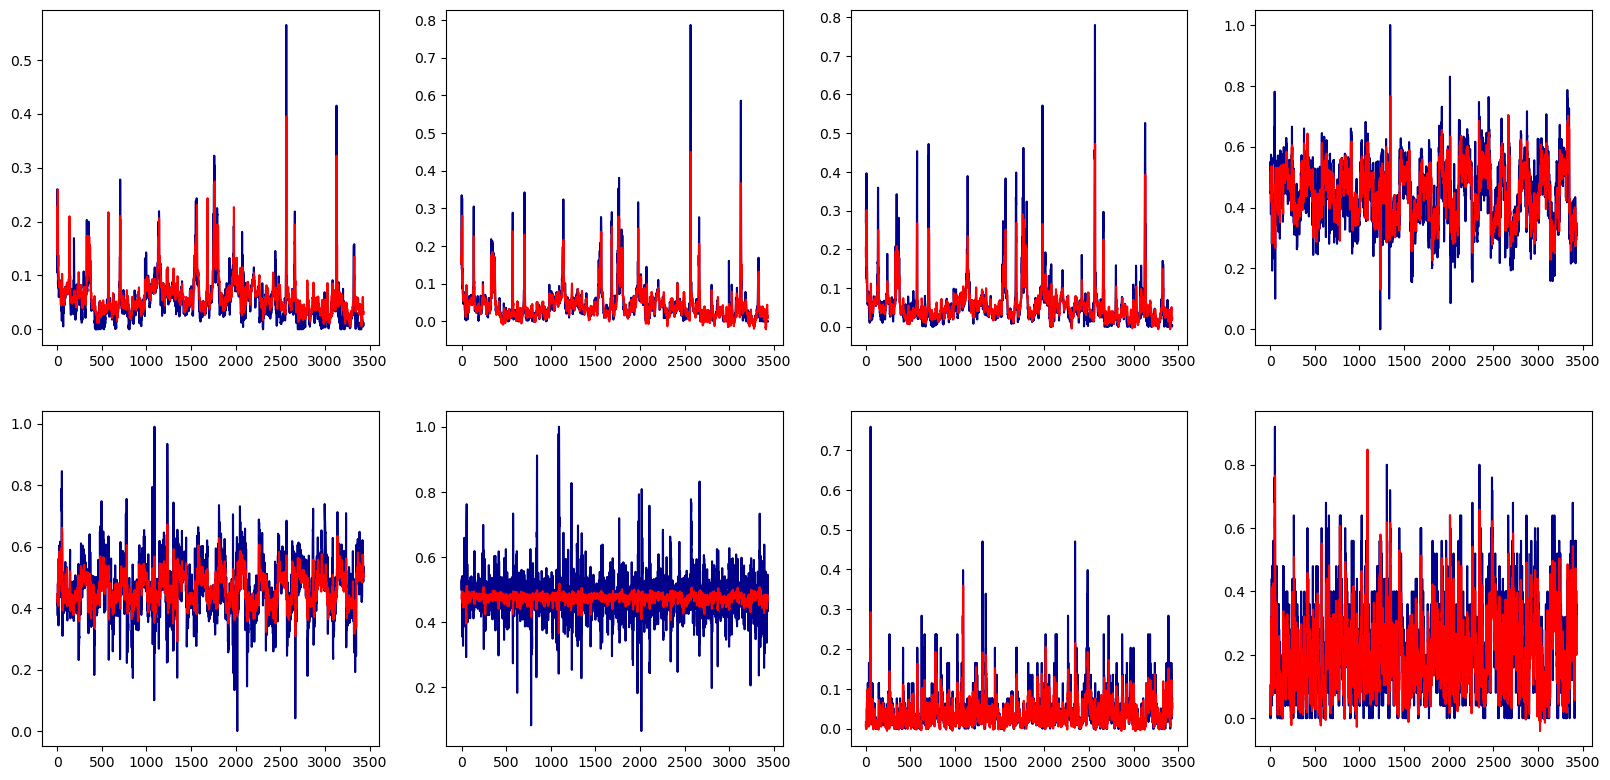

In [14]:
plt.figure(figsize=(20,20))
for j in range(1,9):
    plt.subplot(4,4,j)
    plt.plot(y_test[:,j-1], color = "darkblue")
    plt.plot(y_pred[:,j-1], color = "red")
plt.show()

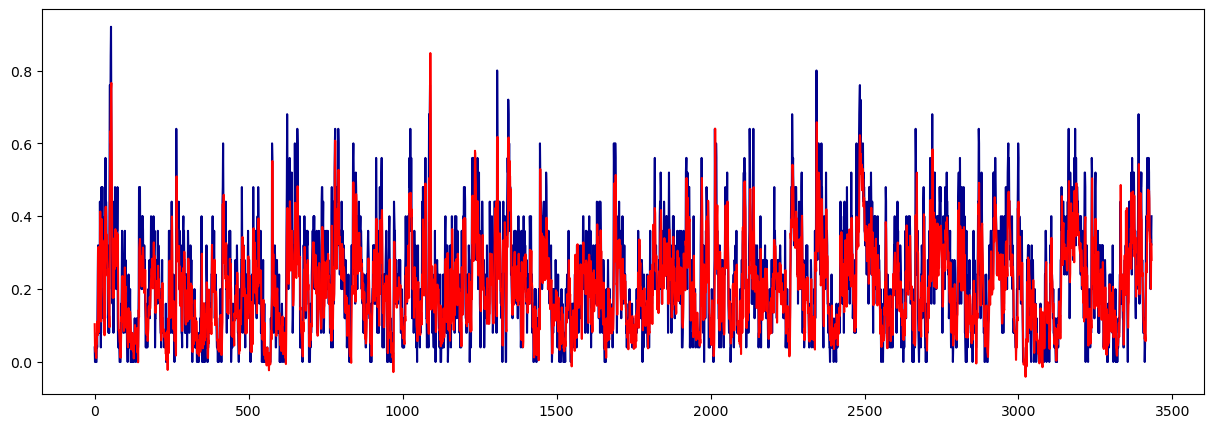

In [17]:
plt.figure(figsize=(15,5))
plt.plot(y_test[:,7], color = "darkblue")
plt.plot(y_pred[:,7], color = "red")
plt.show()

Epoch 1/50
342/342 [==============================] - 62s 148ms/step - loss: 0.0160 - val_loss: 0.0126
Epoch 2/50
342/342 [==============================] - 51s 150ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 3/50
342/342 [==============================] - 50s 147ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 4/50
342/342 [==============================] - 49s 143ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 5/50
342/342 [==============================] - 49s 142ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 6/50
342/342 [==============================] - 50s 146ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 7/50
342/342 [==============================] - 43s 127ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 8/50
342/342 [==============================] - 43s 125ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 9/50
342/342 [==============================] - 43s 127ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 10/50
342/342 [==============================] - 43s 127ms/step - l

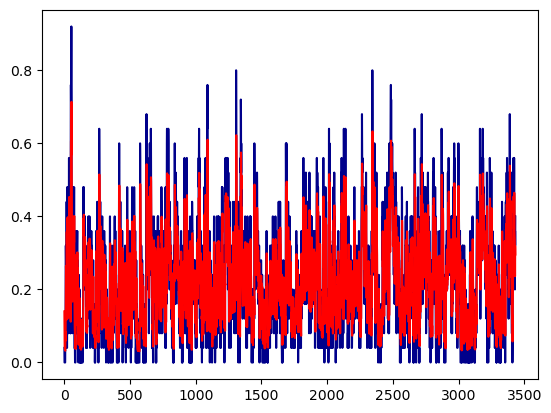

In [18]:
X = X[:,7]
X = np.reshape(X, (X.shape[0], 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, int(len(X)*0.8)):
    X_train.append(X[i-60:i])
    y_train.append(X[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))



# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',   
                               patience=7,            
                               restore_best_weights=True)  

# Entrenar el modelo con EarlyStopping
regressor.fit(X_train, y_train, 
              epochs=50,                     # Número máximo de épocas
              validation_split=0.2, callbacks=[early_stopping]) 


X_test = list()
y_test = list()
for i in range(int(len(X)*0.8), len(X)-1):
    X_test.append(X[i-60:i])
    y_test.append(X[i])
X_test, y_test = np.array(X_test), np.array(y_test)
y_pred = regressor.predict(X_test)

plt.plot(y_test, color = "darkblue")
plt.plot(y_pred, color = "red")
plt.show()